## 1. Get data (The ones for experimentation)

**There are 37 category (class) pet dataset with roughly 200 images for each class.** The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

!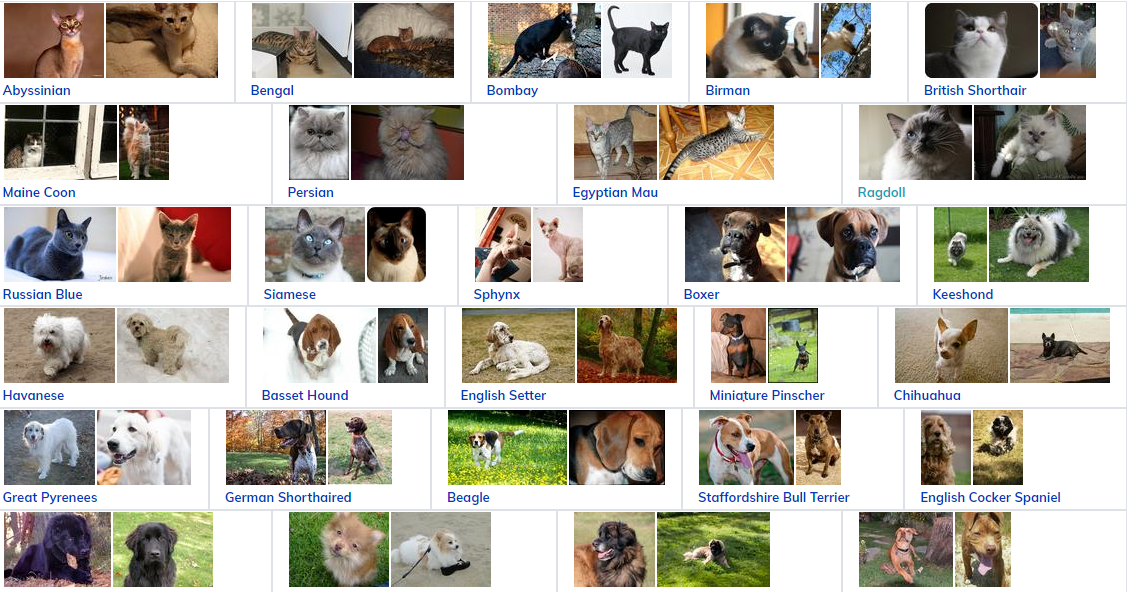

In [1]:
import requests
import zipfile
from pathlib import Path

In [2]:
!rm -rf ./data

In [3]:
# Function to download a zip file from a URL
def download_zip(url, save_path):
    """Downloads a zip file from the given URL and saves it to the specified path."""
    if not save_path.is_file():  # Only download if the file doesn't already exist
        print(f"Downloading data from {url}...")
        response = requests.get(url)
        with open(save_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded and saved at {save_path}.")
    else:
        print(f"{save_path} already exists. Skipping download.")

# Function to unzip a file to a specified directory
def unzip_file(zip_path, extract_to):
    """Unzips a zip file to the specified directory."""
    if not any(extract_to.iterdir()):  # Check if the directory is empty
        print(f"Unzipping {zip_path} to {extract_to}...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Unzipped to {extract_to}.")
    else:
        print(f"{extract_to} is not empty. Skipping unzip.")

# Set up paths for the data folder, train data, and test data
data_path = Path("data/")
train_image_path = data_path / "train_data"
test_image_path = data_path / "test_data"

# Paths to save downloaded zip files
train_zip_path = data_path / "train_data.zip"
test_zip_path = data_path / "test_data.zip"

# Create directories if they don't exist
train_image_path.mkdir(parents=True, exist_ok=True)
test_image_path.mkdir(parents=True, exist_ok=True)

# URLs for train and test zip files
train_url = "https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/raw/master/experimentation_data/train_data.zip"
test_url = "https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/raw/master/experimentation_data/test_data.zip"

# Download train and test data using the function
download_zip(train_url, train_zip_path)
download_zip(test_url, test_zip_path)

# Unzip the downloaded files using the function
unzip_file(train_zip_path, train_image_path)
unzip_file(test_zip_path, test_image_path)




Downloaded and saved at data/train_data.zip.
Downloaded and saved at data/test_data.zip.
Unzipping data/train_data.zip to data/train_data...
Unzipped to data/train_data.
Unzipping data/test_data.zip to data/test_data...
Unzipped to data/test_data.


In [4]:
# Delete the zip file
!rm -rf ./data/test_data.zip
!rm -rf ./data/train_data.zip

### 2. Import PyTorch & set-up device-agnostic

In [5]:
import torch
from torch import nn

torch.__version__

'2.4.1+cu121'

In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 3. Exploratory Data Analysis (EDA)


#### 3.1 Walk through the directories

In [7]:
import os

# Walk through the directories to return their contents
def walk_through_directories(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

walk_through_directories(test_image_path)
walk_through_directories(train_image_path)

There are 1 directories and 0 images in "data/test_data".
There are 1 directories and 0 images in "data/test_data/data".
There are 3 directories and 0 images in "data/test_data/data/images".
There are 0 directories and 20 images in "data/test_data/data/images/boxer".
There are 0 directories and 20 images in "data/test_data/data/images/sphynx".
There are 0 directories and 20 images in "data/test_data/data/images/pug".
There are 1 directories and 0 images in "data/train_data".
There are 1 directories and 0 images in "data/train_data/data".
There are 3 directories and 0 images in "data/train_data/data/images".
There are 0 directories and 80 images in "data/train_data/data/images/boxer".
There are 0 directories and 80 images in "data/train_data/data/images/sphynx".
There are 0 directories and 80 images in "data/train_data/data/images/pug".


#### 3.2 Set up train and testing paths

In [8]:
from pathlib import Path

# Define the path to the 'images' folder inside the unzipped data
test_dir = test_image_path / "data" / "images"
train_dir = train_image_path / "data" / "images"

# Check if this path exists
if test_dir.exists():
    print(f"Test directory: {test_dir}")
    print(f"Train directory: {train_dir}")

    # List the folders (which are the class names) inside the 'images' directory
    class_folders = [f for f in test_dir.iterdir() if f.is_dir()]
    class_folders1 = [f for f in train_dir.iterdir() if f.is_dir()]
    print("Test class folders found:", class_folders)
    print("Train class folders found:", class_folders1)
else:
    print("Test directory doesn't exist, check your path structure.")


Test directory: data/test_data/data/images
Train directory: data/train_data/data/images
Test class folders found: [PosixPath('data/test_data/data/images/boxer'), PosixPath('data/test_data/data/images/sphynx'), PosixPath('data/test_data/data/images/pug')]
Train class folders found: [PosixPath('data/train_data/data/images/boxer'), PosixPath('data/train_data/data/images/sphynx'), PosixPath('data/train_data/data/images/pug')]


#### 3.3 Visualize images randomly

In [9]:
import random
from PIL import Image

def display_image(data_path):
  # Set seed
  #random.seed(150)

  # retrieve all image paths
  image_path_list = list(data_path.glob("*/*/*/*.jpg"))

  # get random image path
  random_image_path = random.choice(image_path_list)

  # Get image class from path name (the image class is the name of the directory where the image is stored)
  image_class = random_image_path.parent.stem

  # open image
  img = Image.open(random_image_path)

  # print metadata
  print(f"Random image path: {random_image_path}")
  print(f"Image class: {image_class}")
  print(f"Image height: {img.height}")
  print(f"Image width: {img.width}")

  return img



Random image path: data/test_data/data/images/pug/pug_191.jpg
Image class: pug
Image height: 225
Image width: 300


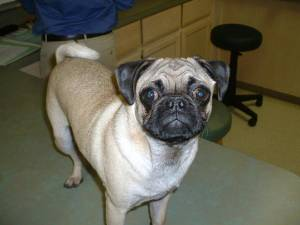

In [10]:
# print a random test image
display_image(test_image_path)

Random image path: data/train_data/data/images/sphynx/Sphynx_72.jpg
Image class: sphynx
Image height: 500
Image width: 500


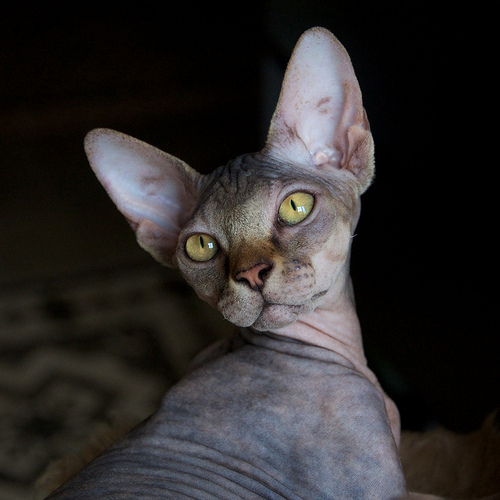

In [11]:
# print a random train image
display_image(train_image_path)

### 4. Transforming data

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transform data using function

In [13]:
# Transform image
image_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),   # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() ])       # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0

In [14]:
import matplotlib.pyplot as plt

# Function to transform and plot images
def transform_images(path_image, transform, n=3):
    # Collect all image paths from subdirectories (recursively)
    image_extensions = ['**/*.jpg', '**/*.jpeg', '**/*.png', '**/*.bmp', '**/*.tiff']
    image_path_list = []
    for ext in image_extensions:
        image_path_list.extend(list(path_image.glob(ext)))

    # Print the image paths found
    print(f"Collected image paths: {image_path_list}")

    print(f"Total images available: {len(image_path_list)}")

    if len(image_path_list) < n:
        print(f"Only {len(image_path_list)} images available, using all.")
        n = len(image_path_list)

    image_random_path = random.sample(image_path_list, k=n)

    for i in image_random_path:
        with Image.open(i) as file_name:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(file_name)
            ax[0].set_title(f"Original image \nSize: {file_name.size}")
            ax[0].axis("off")

            transformed_image = transform(file_name).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {i.parent.stem}", fontsize=16)



In [15]:
# Set up path to data folders
data_path = Path("data/")
test_image_path = data_path / "test_data/data/images"
train_image_path = data_path / "train_data/data/images"


Transforming test images:
Collected image paths: [PosixPath('data/test_data/data/images/boxer/boxer_79.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_144.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_184.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_20.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_150.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_110.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_122.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_78.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_85.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_51.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_80.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_67.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_50.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_56.jpg'), PosixPath('data/test_data/data/images/boxer/boxer_125.jpg'), PosixPath('data/test_data/data/images/boxer

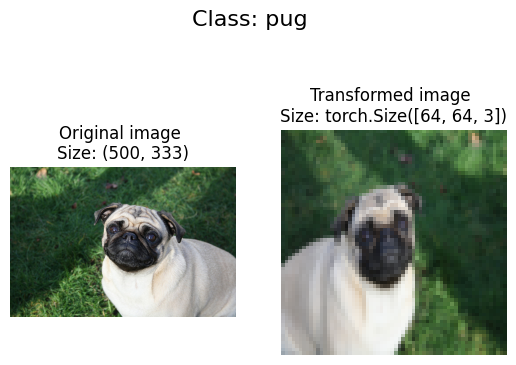

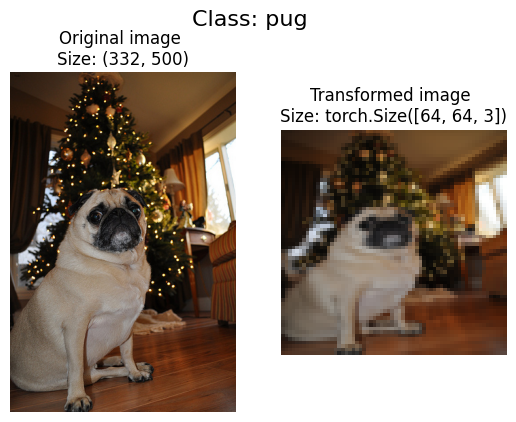

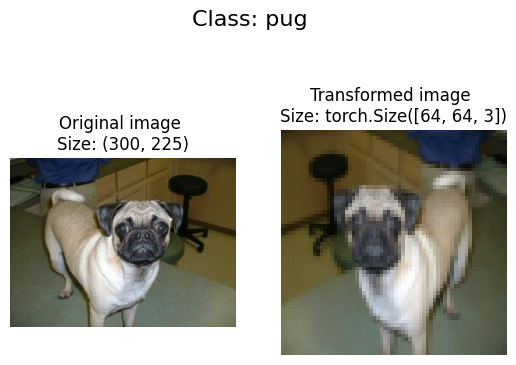

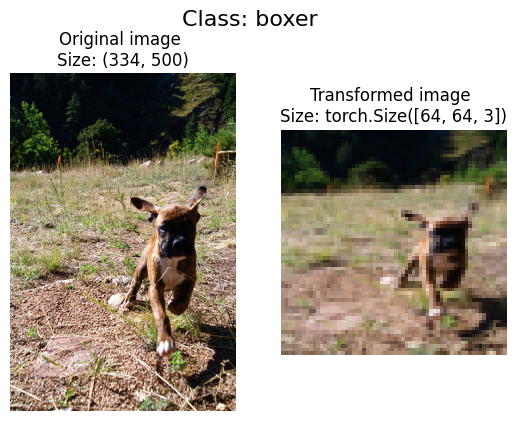

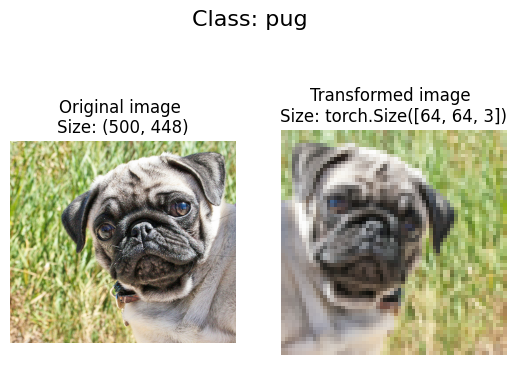

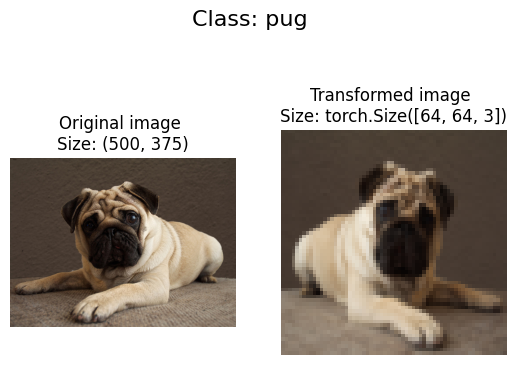

In [16]:
# Transform images
if test_image_path:  # Check if there are images to transform
    print("\nTransforming test images:")
    transform_images(test_image_path, transform=image_transform, n=3)

if train_image_path:  # Check if there are images to transform
    print("\nTransforming train images:")
    transform_images(train_image_path, transform=image_transform, n=3)

### 4. Loading Image Data using ImageFolder

In [17]:
# Create datasets that is capable of being used with PyTorch using ImageFolder
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,  # target folder of images
                                  transform=image_transform,   # transforms to perform on data (images)
                                  target_transform=None)   # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=image_transform)

print(f"Train data: \n{train_data}\nTest data: \n{test_data}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 240
    Root location: data/train_data/data/images
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data: 
Dataset ImageFolder
    Number of datapoints: 60
    Root location: data/test_data/data/images
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


#### 4.1 Inspect datasets

In [18]:
# list of class names
class_names = train_data.classes
class_names1 = test_data.classes

class_names, class_names1

(['boxer', 'pug', 'sphynx'], ['boxer', 'pug', 'sphynx'])

In [19]:
# Dictionary of class names
class_dict = train_data.class_to_idx
class_dict1 = test_data.class_to_idx

class_dict, class_dict1

({'boxer': 0, 'pug': 1, 'sphynx': 2}, {'boxer': 0, 'pug': 1, 'sphynx': 2})

In [20]:
# Check the lengths
len(train_data), len(test_data)

(240, 60)

In [21]:
image, label = train_data[0][0], train_data[0][1]

print(f"Train Image tensor:\n{image}")
print(f"Train Image shape: {image.shape}")
print(f"Train Image datatype: {image.dtype}")
print(f"Train Image label: {label}")
print(f"Train Label datatype: {type(label)}")

Train Image tensor:
tensor([[[0.2314, 0.2078, 0.2118,  ..., 0.3765, 0.5569, 0.5922],
         [0.2275, 0.2039, 0.2039,  ..., 0.3843, 0.5490, 0.5765],
         [0.2275, 0.2118, 0.2157,  ..., 0.3804, 0.5765, 0.5647],
         ...,
         [0.7020, 0.6902, 0.6196,  ..., 0.5608, 0.5451, 0.5294],
         [0.7059, 0.6784, 0.6196,  ..., 0.5569, 0.5451, 0.5216],
         [0.6667, 0.6471, 0.5882,  ..., 0.5569, 0.5451, 0.5216]],

        [[0.2353, 0.2863, 0.2863,  ..., 0.4784, 0.5529, 0.5961],
         [0.2196, 0.2549, 0.2745,  ..., 0.4392, 0.4941, 0.5569],
         [0.2118, 0.2588, 0.3020,  ..., 0.4118, 0.4863, 0.5137],
         ...,
         [0.6588, 0.6431, 0.6000,  ..., 0.5020, 0.4902, 0.4706],
         [0.6588, 0.6431, 0.6078,  ..., 0.4941, 0.4824, 0.4627],
         [0.6118, 0.6078, 0.5686,  ..., 0.4863, 0.4745, 0.4549]],

        [[0.1451, 0.1608, 0.1686,  ..., 0.2353, 0.3529, 0.3961],
         [0.1412, 0.1490, 0.1529,  ..., 0.2431, 0.3412, 0.3843],
         [0.1294, 0.1255, 0.1333,  ...

##### NOTE: The images are in the form of a tensor of shape [3, 64, 64] and the labels are in the form of an integer relating to a specific class (as referenced by the class_to_idx attribute).

### 5.0 Turn loaded images into DataLoaders
Turning our Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

In [22]:
# Change train and test Datasets into DataLoaders to make them iterable
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=10,  # sample size per batch
                              num_workers=1,   # how many subprocesses to use for data loading (higher = more)
                              shuffle=True) # shuffle the data

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=10,
                              num_workers=1,
                              shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cf9672eb970>,
 <torch.utils.data.dataloader.DataLoader at 0x7cf9672eba90>)

In [23]:
# Assuming you have defined a DataLoader, e.g., `train_loader`
for img, label in train_dataloader:
    # Print the shape of the image and label
    print(f"Image shape: {img.shape} --> [batch_size, color_channels, height, width]")
    print(f"Label shape: {label.shape}")  # For classification, it might just be a 1D tensor
    break  # Remove this break if you want to check more than one batch


Image shape: torch.Size([10, 3, 64, 64]) --> [batch_size, color_channels, height, width]
Label shape: torch.Size([10])


### 6.0 Model 1: TinyVGG without data *augmentation*

#### 6.1 Create TinyVGG model class for Model 1 "CNN Explainer website."

In [24]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            #nn.Linear(in_features=hidden_units, out_features=output_shape
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)  # Adjust the linear layer size accordingly later (e.g. in_features=hidden_units*16*16)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        x = self.classifier(x)
        print(x.shape)
        return x


# Example usage (assuming train_data is defined)
# Initialize the model
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

#### 6.2 Test the model using forward pass on a single image to fix shape

In [25]:
# get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch and unsqueeze the image to make its shape fit the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print("Single image shape: {img_single.shape}\n")

# Perform a forward pass on a single image
model_1.eval()
with torch.inference_mode():
  pred = model_1(img_single.to(device))

# Print and covert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

# return back to fix "nn.Linear(in_features=hidden_units, out_features=output_shape" based on the shape

Single image shape: {img_single.shape}

torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
Output logits:
tensor([[ 0.0335, -0.0052,  0.0309]])

Output prediction probabilities:
tensor([[0.3379, 0.3251, 0.3370]])

Output prediction label:
tensor([0])

Actual label:
2


#### 6.3 Scan through the model to describe its shape

In [26]:
# Install torchinfo if not available
try:
  import torchinfo
except:
  !pip install torchinfo

from torchinfo import summary

# test pass through the model to get info about it
summary(model_1, input_size=[1, 3, 64, 64])

torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

#### 6.4 Create test and train loop functions

In [27]:
# Train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # instantiate train mode
  model.train()

  # Set up initial values for train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):

    # Send data to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metrics across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [28]:
# Test loop function
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Set up test loss and test accuracy values
  test_loss, test_acc = 0 , 0

  # Turn on inference context manager
  with torch.inference_mode():

    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):

      # send data to target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

#### 6.5 Creating a train() function to combine train_step() and test_step()


In [29]:
from tqdm.auto import tqdm

# Accept various parameters required for the training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):

  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # print out
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
        )

    # Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

#### 6.6 Train and evaluate model 1

In [30]:
# Set device random seed
torch.cuda.manual_seed(42)

# Set epoch number
NUM_EPOCH = 10

# Recreate an instance of TinyVGG
model_1 = TinyVGG(input_shape=3,  # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCH)

# End the timer and print the time it takes to train
end_time = timer()

print(f"Total training time: {end_time - start_time:.4f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.Size([10, 3])
torch.Size([10, 10, 32, 32])
torch.Size([10, 10, 16, 16])
torch.

**train_acc: 0.5875 and test_acc: 0.5333 are pretty bad**

#### 6.7 Plot the loss curves of model 1

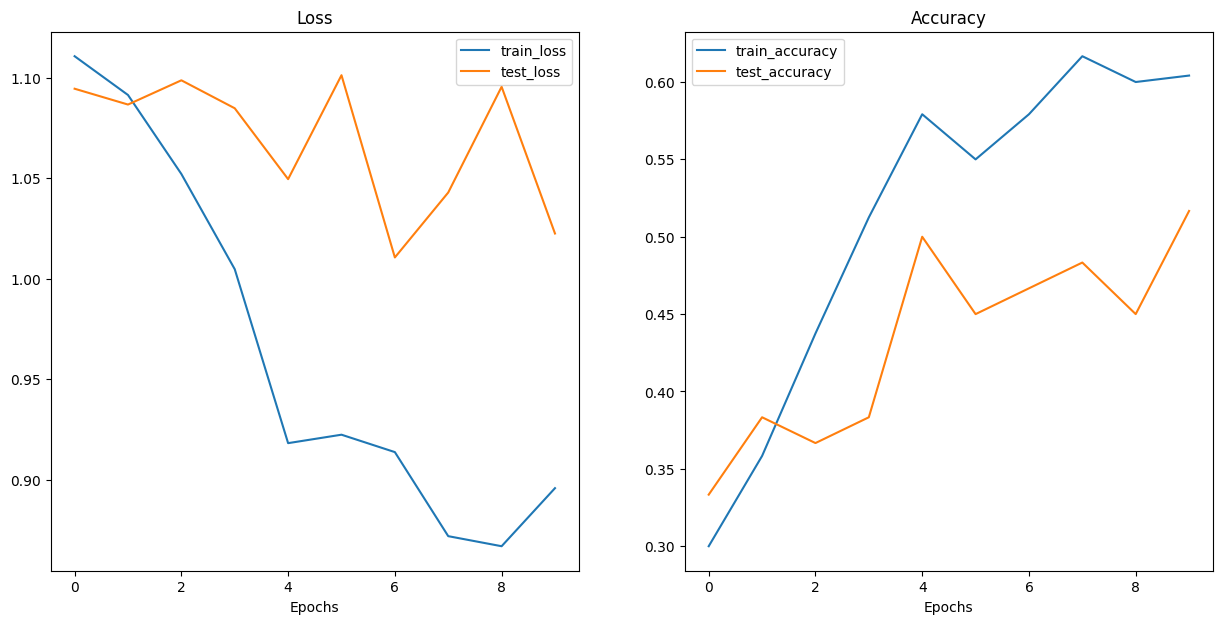

In [31]:
from typing import Dict, List
import matplotlib.pyplot as plt

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(model_1_results)

** Looks good but can be trained longer to see if the loss will drop more**

### 7. Model 2 - TinyVGG with Data Augmetation

#### 7.1 Create transform with data augmentation

In [32]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

#### 7.2 Create train and test datasets and dataloader

In [33]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 240
     Root location: data/train_data/data/images
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 60
     Root location: data/test_data/data/images
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [34]:
# Turn Datasets into DataLoader's
import os


BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cf9665871c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7cf9672eba90>)

#### 7.3 Construct and train model 2

In [35]:
model_2 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_2

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [36]:
# Set random seeds
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_2
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.4f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([16, 10, 32, 32])
torch.Size([16, 10, 16, 16])
torch.Size([16, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([28, 10, 32, 32])
torch.Size([28, 10, 16, 16])
torch.Size([28, 3])
Epoch: 1 | train_loss: 1.1045 | train_acc: 0.3008 | test_loss: 1.0991 | test_acc: 0.3304
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 

#### 7.4 Plot the loss curves of Model 2

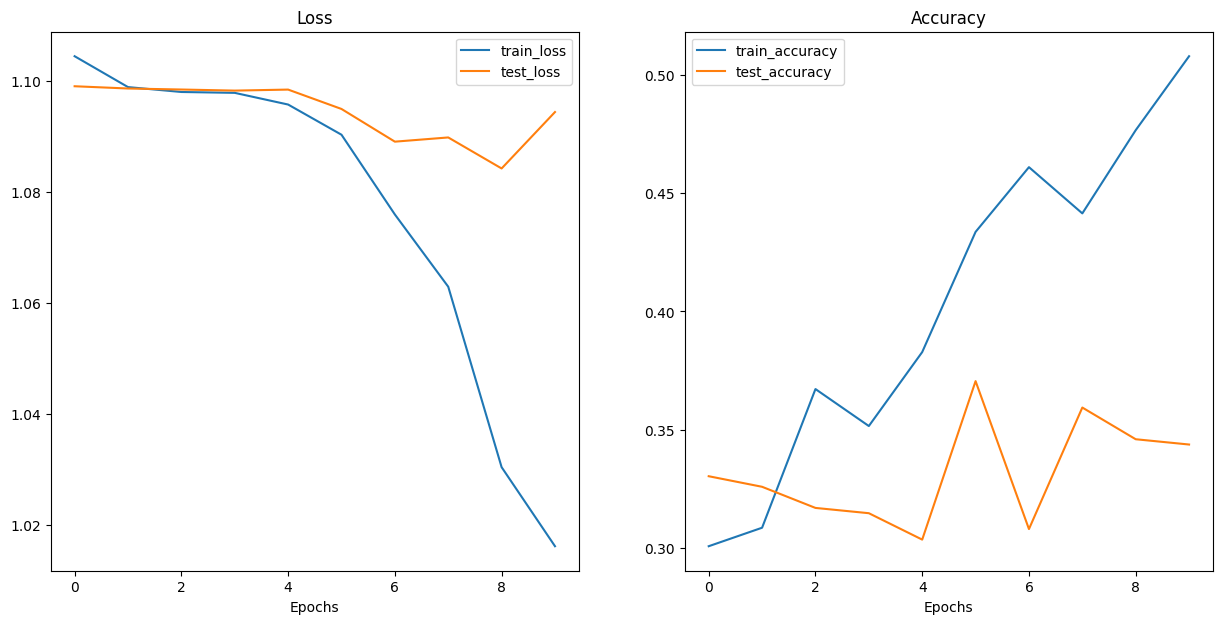

In [37]:
# plot using the function plot_loss_curves previously defined
plot_loss_curves(model_2_results)

** Worse than without augmentation**  

Is it **underfitting** or **overfitting**?

### 8. Compare model results

In [38]:
import pandas as pd
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)

In [39]:
model_1_df

train_loss  train_acc  test_loss  test_acc
0    1.110659   0.300000   1.094501  0.333333
1    1.091383   0.358333   1.086634  0.383333
2    1.052114   0.437500   1.098685  0.366667
3    1.004784   0.512500   1.084785  0.383333
4    0.918298   0.579167   1.049548  0.500000
5    0.922496   0.550000   1.101219  0.450000
6    0.913846   0.579167   1.010621  0.466667
7    0.872054   0.616667   1.042908  0.483333
8    0.867054   0.600000   1.095471  0.450000
9    0.895925   0.604167   1.022521  0.516667

In [40]:
model_2_df

train_loss  train_acc  test_loss  test_acc
0    1.104536   0.300781   1.099124  0.330357
1    1.098973   0.308594   1.098717  0.325893
2    1.098089   0.367188   1.098534  0.316964
3    1.097933   0.351562   1.098338  0.314732
4    1.095827   0.382812   1.098522  0.303571
5    1.090385   0.433594   1.095029  0.370536
6    1.076012   0.460938   1.089135  0.308036
7    1.062985   0.441406   1.089894  0.359375
8    1.030456   0.476562   1.084302  0.345982
9    1.016208   0.507812   1.094475  0.343750

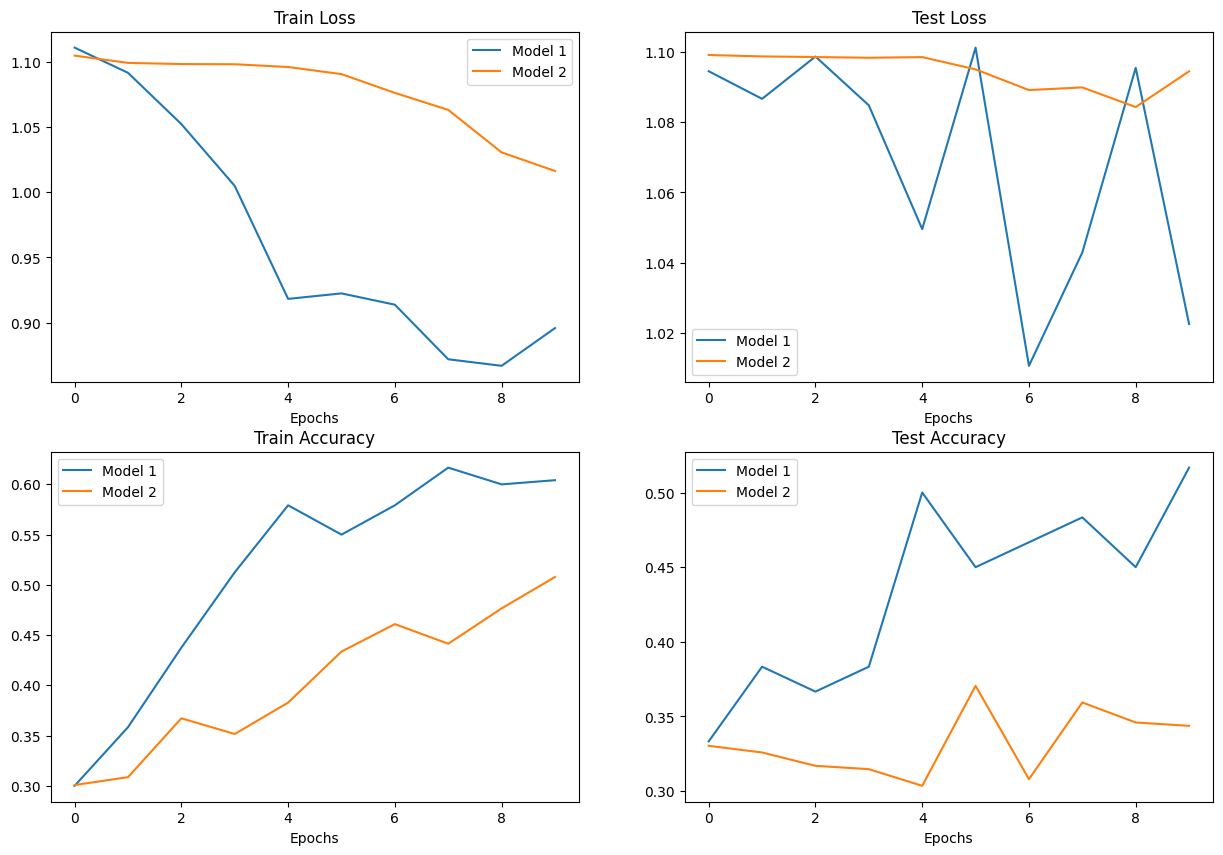

In [41]:
# Plots for both models
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.plot(epochs, model_2_df["train_loss"], label="Model 2")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.plot(epochs, model_2_df["test_loss"], label="Model 2")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.plot(epochs, model_2_df["train_acc"], label="Model 2")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.plot(epochs, model_2_df["test_acc"], label="Model 2")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

**Model 2 looks worse than model 1**

### 9. Make a prediction on a custom image

In [80]:
!rm -rf ./data/Sphynx-Cat-Breed-Guide.jpg

In [81]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "Sphynx-Cat-Breed-Guide.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # request = requests.get("https://images.ctfassets.net/m5ehn3s5t7ec/wp-image-198376/449e05567fe00a8f4cf1ed874d636a0d/Sphynx-Cat-Breed-Guide.jpg") # sphynx
        # request = requests.get("https://images2.fanpop.com/image/photos/13700000/Beautiful-Pug-pugs-13728067-1600-1200.jpg")  # pug
        request = requests.get("https://cdn.britannica.com/46/233846-050-8D30A43B/Boxer-dog.jpg")  # boxer
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

#### 9.1 Loading the custom image with PyTorch

In [82]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")


Custom image tensor:
tensor([[[145, 146, 148,  ..., 128, 128, 128],
         [146, 146, 148,  ..., 129, 129, 129],
         [146, 146, 147,  ..., 130, 130, 130],
         ...,
         [200, 162, 148,  ..., 105,  89,  75],
         [230, 194, 168,  ..., 103,  82,  68],
         [195, 190, 170,  ..., 111,  67,  67]],

        [[166, 167, 167,  ..., 155, 154, 154],
         [167, 167, 167,  ..., 156, 155, 155],
         [166, 166, 167,  ..., 157, 156, 156],
         ...,
         [191, 160, 162,  ..., 106, 112, 110],
         [226, 196, 182,  ..., 110, 117, 118],
         [195, 196, 184,  ..., 122, 108, 123]],

        [[ 75,  76,  77,  ...,  78,  80,  80],
         [ 76,  76,  77,  ...,  79,  81,  81],
         [ 77,  77,  78,  ...,  80,  82,  82],
         ...,
         [116,  85,  87,  ...,  28,  24,  16],
         [153, 121, 105,  ...,  32,  27,  21],
         [123, 122, 105,  ...,  43,  16,  26]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 1102, 1600])

Custom image dty

#### 9.2 Convert tensor value to float32

In [83]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.5686, 0.5725, 0.5804,  ..., 0.5020, 0.5020, 0.5020],
         [0.5725, 0.5725, 0.5804,  ..., 0.5059, 0.5059, 0.5059],
         [0.5725, 0.5725, 0.5765,  ..., 0.5098, 0.5098, 0.5098],
         ...,
         [0.7843, 0.6353, 0.5804,  ..., 0.4118, 0.3490, 0.2941],
         [0.9020, 0.7608, 0.6588,  ..., 0.4039, 0.3216, 0.2667],
         [0.7647, 0.7451, 0.6667,  ..., 0.4353, 0.2627, 0.2627]],

        [[0.6510, 0.6549, 0.6549,  ..., 0.6078, 0.6039, 0.6039],
         [0.6549, 0.6549, 0.6549,  ..., 0.6118, 0.6078, 0.6078],
         [0.6510, 0.6510, 0.6549,  ..., 0.6157, 0.6118, 0.6118],
         ...,
         [0.7490, 0.6275, 0.6353,  ..., 0.4157, 0.4392, 0.4314],
         [0.8863, 0.7686, 0.7137,  ..., 0.4314, 0.4588, 0.4627],
         [0.7647, 0.7686, 0.7216,  ..., 0.4784, 0.4235, 0.4824]],

        [[0.2941, 0.2980, 0.3020,  ..., 0.3059, 0.3137, 0.3137],
         [0.2980, 0.2980, 0.3020,  ..., 0.3098, 0.3176, 0.3176],
         [0.3020, 0.3020, 0.3059,  ..

#### 9.3 Predicting custom image

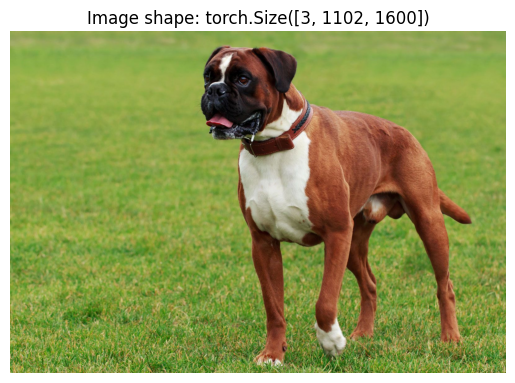

In [84]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [85]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")


Original shape: torch.Size([3, 1102, 1600])
New shape: torch.Size([3, 64, 64])


In [86]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])


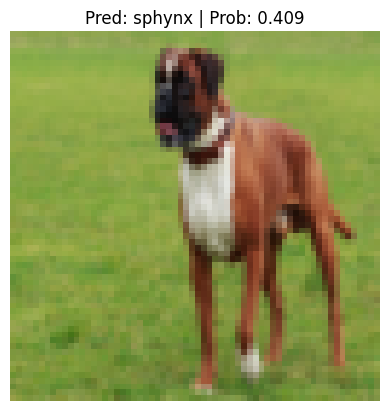

In [87]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)